## Imports and Preprocess

In [605]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
from scipy import stats

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(15,5)})

In [606]:
def calculate_corr_ci(df1, df2, alpha=0.05):
    correlations = []
    ci_lower = []
    ci_upper = []

    for column in df1.columns:
        r, _ = stats.pearsonr(df1[column], df2[column])
        r_z = np.arctanh(r)
        se = 1/np.sqrt(df1[column].size-3)
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))

        correlations.append(r)
        ci_lower.append(lo)
        ci_upper.append(hi)

    return correlations, ci_lower, ci_upper

Read result files

In [607]:
users = pd.read_csv('results/Calibrated Predictions Survey - users.csv', index_col='id')
preds = pd.read_csv('results/Calibrated Predictions Survey - predictions.csv', index_col='id')
labels = pd.read_csv('results/Calibrated Predictions Survey - labels.csv', index_col='id')
pred_test = pd.read_csv('results/Calibrated Predictions Survey - pred_test.csv', index_col='id')
label_test = pd.read_csv('results/Calibrated Predictions Survey - outcome_test.csv', index_col='id')
first_rate = pd.read_csv('results/Calibrated Predictions Survey - first_rate.csv', index_col='id')
last_rate = pd.read_csv('results/Calibrated Predictions Survey - last_rate.csv', index_col='id')

Replace values in data

In [608]:
preds_outcome = preds.applymap(lambda x: 1 if x >= 50 else 0)

map = {"Yes": 1, "No": 0}
label_test = label_test.applymap(lambda x: map.get(x, -1))

Get every model indexes

In [609]:
# get all unique models names in users that start with 'NN'
models_names = [model for model in users['model_name'].unique() if model.startswith('NN')]
model_names = models_names.sort()
model_indexes = {}

# get indexes of every model name
for model in models_names:
    model_indexes[model] = users.index[users['model_name'] == model].tolist()

## Average users trust in the system

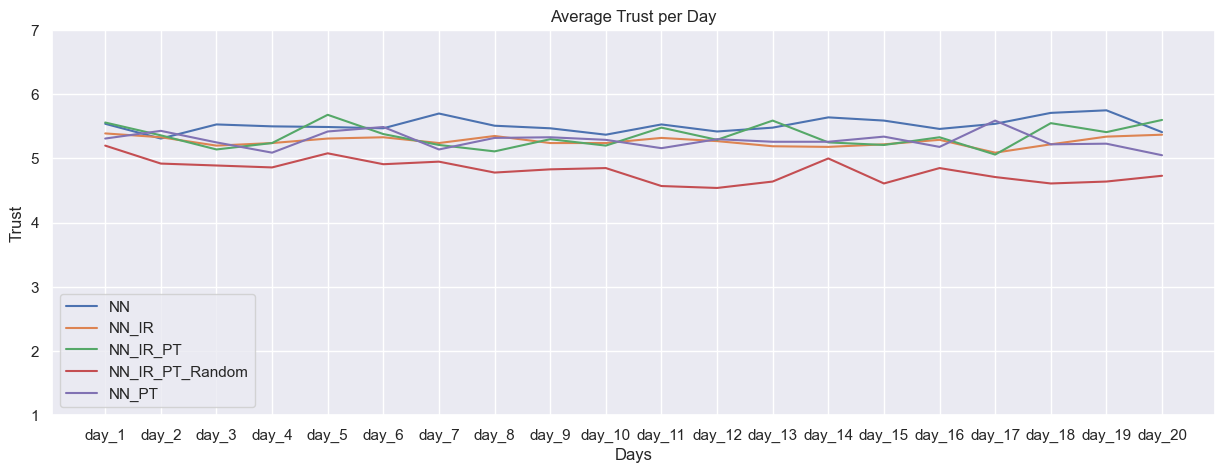

In [610]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

## Users actions according to system predictions

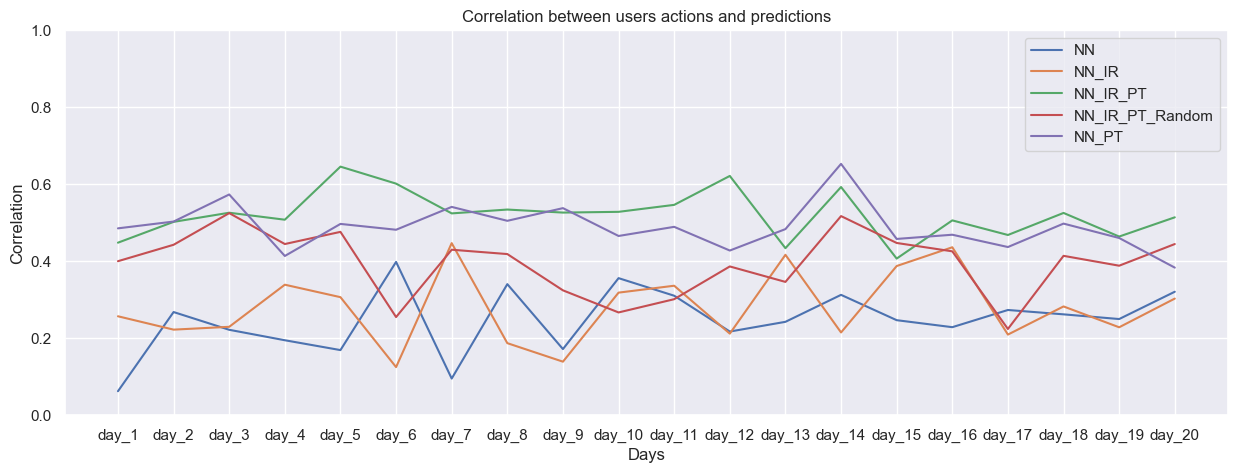

In [611]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    first_rate_model = first_rate.loc[model_indexes[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

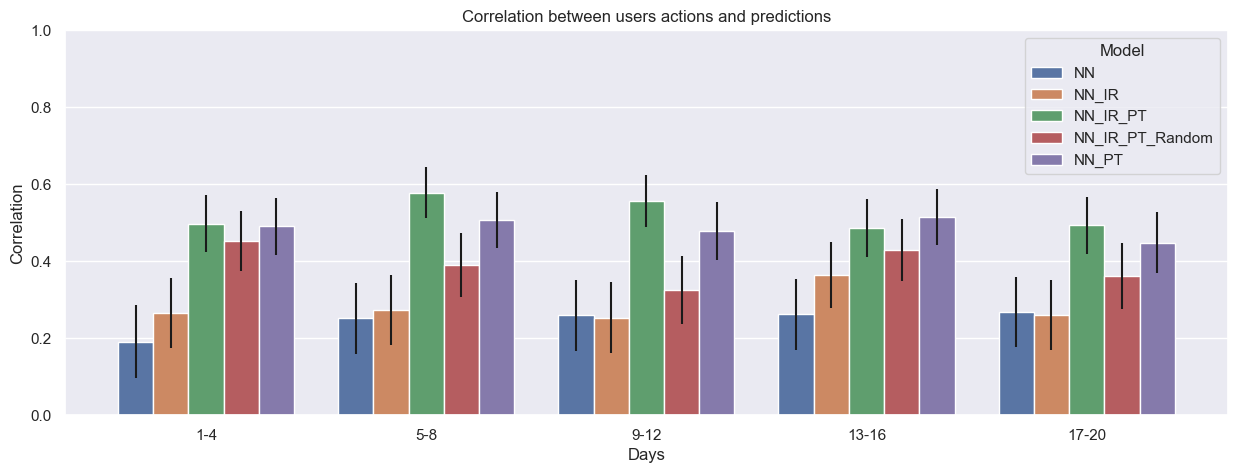

In [612]:
# calculate and plot correlation between model prediction and first_rate for each model
df_corr_ci = pd.DataFrame({'Model': [], 'Correlation': [], 'CI Lower': [], 'CI Upper': [], 'Day': []})

num_days_in_group = 4
grouped_days = [preds.columns[i:i+num_days_in_group] for i in range(0, len(preds.columns), num_days_in_group)]
grouped_days_names = ['1-4', '5-8', '9-12', '13-16', '17-20']

for i, model in enumerate(models_names):
    preds_model = preds.loc[model_indexes[model]]
    grouped_preds_model = pd.DataFrame()
    for group in grouped_days:
        grouped_preds_model = pd.concat([grouped_preds_model, preds_model[group].apply(list, axis=1)], axis=1)
    grouped_preds_model.columns = grouped_days_names
    grouped_preds_model = grouped_preds_model.explode(grouped_days_names)
    
    first_rate_model = first_rate.loc[model_indexes[model]]
    grouped_first_rate_model = pd.DataFrame()
    for group in grouped_days:
        grouped_first_rate_model = pd.concat([grouped_first_rate_model, first_rate_model[group].apply(list, axis=1)], axis=1)
    grouped_first_rate_model.columns = grouped_days_names
    grouped_first_rate_model = grouped_first_rate_model.explode(grouped_days_names)

    correlations, ci_lower, ci_upper = calculate_corr_ci(grouped_preds_model, grouped_first_rate_model)
    new_rows = pd.DataFrame({'Correlation': correlations, 'CI Lower': ci_lower, 'CI Upper': ci_upper, 'Model': model, 'Day': grouped_preds_model.columns})
    df_corr_ci = pd.concat([df_corr_ci, new_rows], ignore_index=True)

df_corr_ci['errorbar'] = (df_corr_ci['CI Upper'] - df_corr_ci['CI Lower'])/2

plt.figure(figsize=(15, 5))  
ax = sns.barplot(data=df_corr_ci, x='Day', y='Correlation', hue='Model')#, errorbar=('ci', 0.9), edgecolor='black')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=df_corr_ci['errorbar'], fmt="none", c="k")

ax.set(ylim=(0, 1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

## Statistical significance on correlations

In [613]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])
    cors_model = preds_model.corrwith(first_rate_model, axis=1, method='pearson')
    cors_model = cors_model.dropna(how='any')
    cors[model] = cors_model.reset_index(drop=True)

# remove Nans
cors = cors.dropna(how='any')
cors

,NN,NN_IR,NN_IR_PT,NN_IR_PT_Random,NN_PT
0,0.448828,0.314570,0.969154,0.375082,0.469772
1,-0.256032,0.936035,0.966548,0.262740,0.996689
2,-0.158859,-0.167374,0.879789,0.926679,0.972736
3,0.468953,0.518338,0.982792,0.981287,0.524383
4,0.200715,0.011549,-0.003664,0.865728,0.973593
...,...,...,...,...,...
84,0.200742,0.119524,-0.084832,0.052678,0.961690
85,0.059012,0.970105,0.981768,0.691236,0.508187
86,0.234975,0.977713,-0.313418,0.005354,0.873194
87,-0.180048,-0.213440,0.988876,0.493985,0.994460


In [614]:
print(cors.mean())

# check statistical significance between models with two tails t-test
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        t_statistic, p_value = stats.f_oneway(cors[model1], cors[model2])
        print(f'{model1} vs {model2}: f_statistic={t_statistic}, p_value={p_value}')

NN                 0.241284
NN_IR              0.244279
NN_IR_PT           0.451873
NN_IR_PT_Random    0.425633
NN_PT              0.479945
dtype: float64
NN vs NN_IR: f_statistic=0.0015767308791200328, p_value=0.9683708739394632
NN vs NN_IR_PT: f_statistic=8.452340106081957, p_value=0.004115080363494833
NN vs NN_IR_PT_Random: f_statistic=6.520205983901175, p_value=0.01151390130853745
NN vs NN_PT: f_statistic=9.501077875750134, p_value=0.0023842477707408673
NN_IR vs NN_IR_PT: f_statistic=8.339482812369072, p_value=0.004366118883069222
NN_IR vs NN_IR_PT_Random: f_statistic=6.407399676433413, p_value=0.012240324844184976
NN_IR vs NN_PT: f_statistic=9.388106789682954, p_value=0.0025276818699834012
NN_IR_PT vs NN_IR_PT_Random: f_statistic=0.14685542173369168, p_value=0.7020211951980917
NN_IR_PT vs NN_PT: f_statistic=0.14402193736143612, p_value=0.7047724561925319
NN_IR_PT_Random vs NN_PT: f_statistic=0.5425536455546647, p_value=0.4623570154524925


## Statistical significance on trust

In [615]:
trust = pd.DataFrame(columns=models_names)

# create dataframe of avg trust of users for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model = last_rate_model.mean(axis=1)
    trust[model] = last_rate_model.reset_index(drop=True)

trust

,NN,NN_IR,NN_IR_PT,NN_IR_PT_Random,NN_PT
0,2.65,5.90,6.85,4.80,4.25
1,6.45,6.90,5.35,5.80,6.00
2,5.10,5.70,3.30,2.20,4.20
3,5.40,6.10,5.60,6.80,4.60
4,6.85,5.55,5.60,5.90,3.80
...,...,...,...,...,...
95,5.40,5.85,5.75,4.45,4.00
96,4.60,6.15,5.80,1.90,5.95
97,4.80,5.15,6.15,4.15,4.65
98,6.15,5.50,4.85,6.05,2.65


In [616]:
print(trust.mean())
print()

# check statistical significance between models with repeated measures ANOVA
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        f_statistic, p_value = stats.f_oneway(trust[model1], trust[model2])
        print(f'{model1} vs {model2}: f_statistic={f_statistic}, p_value={p_value}')

NN                 5.5210
NN_IR              5.2680
NN_IR_PT           5.3475
NN_IR_PT_Random    4.8085
NN_PT              5.2830
dtype: float64

NN vs NN_IR: f_statistic=5.060666754513112, p_value=0.02557538870630818
NN vs NN_IR_PT: f_statistic=2.159700560430083, p_value=0.14325942909284908
NN vs NN_IR_PT_Random: f_statistic=20.320521574394615, p_value=1.1196035337144704e-05
NN vs NN_PT: f_statistic=3.6369836626953, p_value=0.05795682415704275
NN_IR vs NN_IR_PT: f_statistic=0.49355735845090243, p_value=0.48316983712128747
NN_IR vs NN_IR_PT_Random: f_statistic=8.852920345830354, p_value=0.0032905083915647083
NN_IR vs NN_PT: f_statistic=0.015579788450603161, p_value=0.9007934603848875
NN_IR_PT vs NN_IR_PT_Random: f_statistic=11.556304459761376, p_value=0.0008164573913833756
NN_IR_PT vs NN_PT: f_statistic=0.26445157478210474, p_value=0.6076517076680874
NN_IR_PT_Random vs NN_PT: f_statistic=8.408691387691796, p_value=0.004156056201455211


---
## Participants Errors

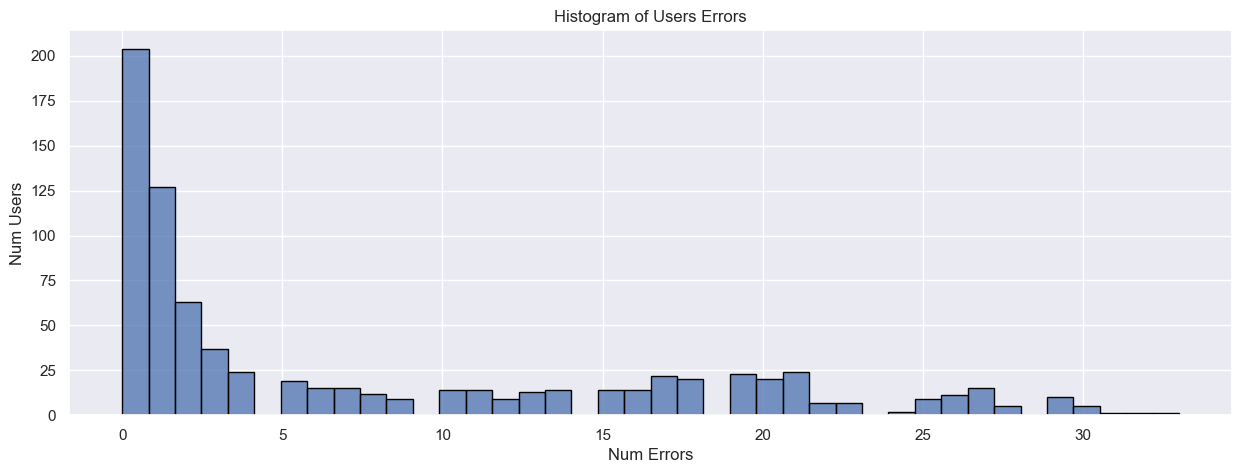

In [617]:
# calculate participants' errors
users_label_error = (labels != label_test).sum(axis=1)
users_pred_error = pred_test.apply(lambda x: (abs(x - preds.loc[x.name]) > 5).sum(), axis=1)
users_error = users_label_error + users_pred_error

# plot histogram of participants' error
p = sns.histplot(users_error, bins=40, edgecolor='black')
p.set(title='Histogram of Users Errors', xlabel='Num Errors', ylabel='Num Users')
plt.show()

---
## Analysis of good participants

In [618]:
allowed_errors = 20

good_users_idx = users_error[users_error <= allowed_errors].index
print(f'Number of users with less than {allowed_errors} errors is: {len(good_users_idx)}')
# sort from high to low users error in the range index of 100 to 206
# print(users_error[100:206].sort_values(ascending=False).head(10))

Number of users with less than 20 errors is: 702


Get every model indexes

In [619]:
# get good users
users_good = users.loc[good_users_idx]
model_indexes_good = {}

# get indexes of every model name
for model in models_names:
    model_indexes_good[model] = users_good.index[users_good['model_name'] == model].tolist()

## Average good users trust in the system

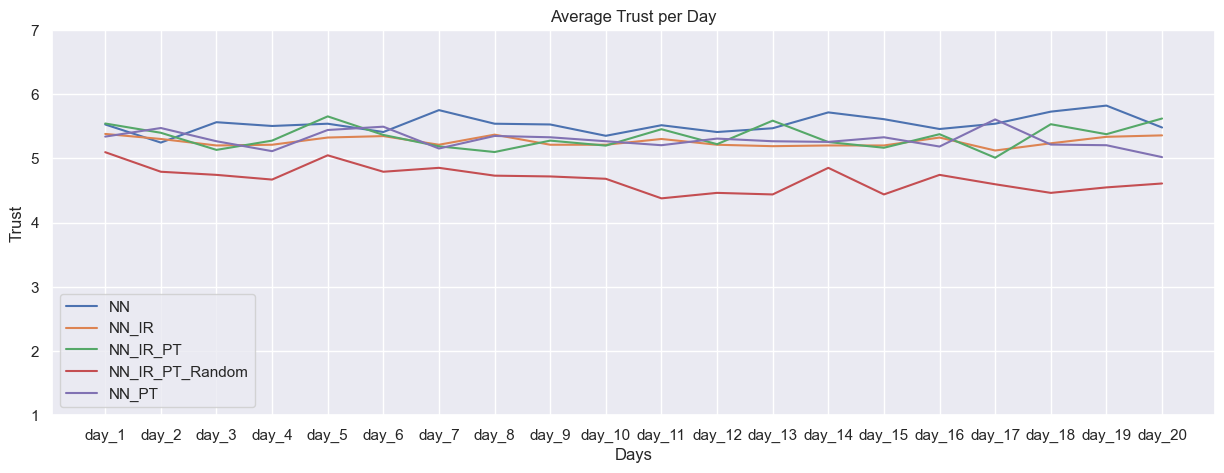

In [620]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes_good[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

## Good users actions according to system predictions

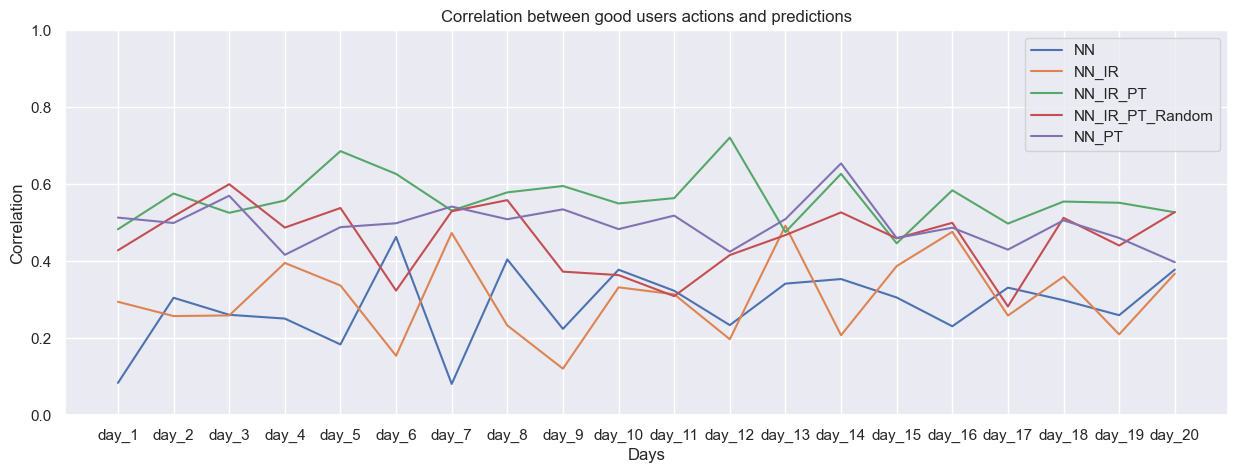

In [621]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between good users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

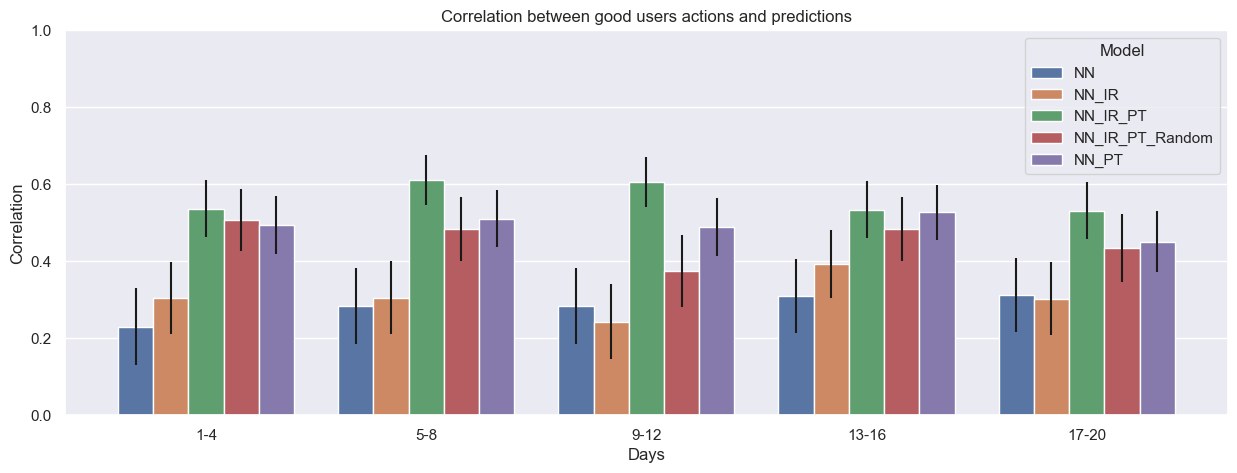

In [622]:
# calculate and plot correlation between model prediction and first_rate for each model
df_corr_ci = pd.DataFrame({'Model': [], 'Correlation': [], 'CI Lower': [], 'CI Upper': [], 'Day': []})

num_days_in_group = 4
grouped_days = [preds.columns[i:i+num_days_in_group] for i in range(0, len(preds.columns), num_days_in_group)]
grouped_days_names = ['1-4', '5-8', '9-12', '13-16', '17-20']

for i, model in enumerate(models_names):
    preds_model = preds.loc[model_indexes_good[model]]
    grouped_preds_model = pd.DataFrame()
    for group in grouped_days:
        grouped_preds_model = pd.concat([grouped_preds_model, preds_model[group].apply(list, axis=1)], axis=1)
    grouped_preds_model.columns = grouped_days_names
    grouped_preds_model = grouped_preds_model.explode(grouped_days_names)
    
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    grouped_first_rate_model = pd.DataFrame()
    for group in grouped_days:
        grouped_first_rate_model = pd.concat([grouped_first_rate_model, first_rate_model[group].apply(list, axis=1)], axis=1)
    grouped_first_rate_model.columns = grouped_days_names
    grouped_first_rate_model = grouped_first_rate_model.explode(grouped_days_names)

    correlations, ci_lower, ci_upper = calculate_corr_ci(grouped_preds_model, grouped_first_rate_model)
    new_rows = pd.DataFrame({'Correlation': correlations, 'CI Lower': ci_lower, 'CI Upper': ci_upper, 'Model': model, 'Day': grouped_preds_model.columns})
    df_corr_ci = pd.concat([df_corr_ci, new_rows], ignore_index=True)

df_corr_ci['errorbar'] = (df_corr_ci['CI Upper'] - df_corr_ci['CI Lower'])/2

plt.figure(figsize=(15, 5))  
ax = sns.barplot(data=df_corr_ci, x='Day', y='Correlation', hue='Model')#, errorbar=('ci', 0.9), edgecolor='black')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=df_corr_ci['errorbar'], fmt="none", c="k")

ax.set(ylim=(0, 1), title='Correlation between good users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

## Check statistical significance on correlations

In [623]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])
    cors_model = first_rate_model.corrwith(preds_model, axis=1, method='pearson')
    cors_model = cors_model.dropna(how='any')
    cors[model] = cors_model.reset_index(drop=True)

cors = cors.dropna(how='any')
cors

,NN,NN_IR,NN_IR_PT,NN_IR_PT_Random,NN_PT
0,0.448828,0.314570,0.969154,0.375082,0.469772
1,-0.256032,0.936035,0.966548,0.262740,0.996689
2,-0.158859,-0.167374,0.879789,0.926679,0.972736
3,0.468953,0.518338,0.982792,0.981287,0.524383
4,0.200715,0.011549,-0.003664,0.865728,0.973593
...,...,...,...,...,...
69,0.269513,0.947000,-0.256026,0.971577,0.023395
70,0.987550,-0.031338,0.323275,0.691236,0.876397
71,0.984932,0.813616,0.447896,0.005354,0.085736
72,0.059012,0.749267,0.913733,0.493985,0.994138


In [624]:
print(cors.mean())
print()

# check statistical significance between models with two tails t-test
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        t_statistic, p_value = stats.f_oneway(cors[model1], cors[model2])
        print(f'{model1} vs {model2}: f_statistic={t_statistic}, p_value={p_value}')

NN                 0.290699
NN_IR              0.255044
NN_IR_PT           0.496481
NN_IR_PT_Random    0.498808
NN_PT              0.493252
dtype: float64

NN vs NN_IR: f_statistic=0.17530491343985813, p_value=0.6760548481714044
NN vs NN_IR_PT: f_statistic=6.755614987533693, p_value=0.010304477201682151
NN vs NN_IR_PT_Random: f_statistic=6.714091450120071, p_value=0.010536103304101319
NN vs NN_PT: f_statistic=5.628868744443087, p_value=0.01897031924215696
NN_IR vs NN_IR_PT: f_statistic=9.251819065049318, p_value=0.002789935907942817
NN_IR vs NN_IR_PT_Random: f_statistic=9.165936750365724, p_value=0.002915704727085816
NN_IR vs NN_PT: f_statistic=7.750632617085234, p_value=0.00608079836969988
NN_IR_PT vs NN_IR_PT_Random: f_statistic=0.0009847037516042775, p_value=0.9750093558725134
NN_IR_PT vs NN_PT: f_statistic=0.0016446302748266987, p_value=0.9677068277836808
NN_IR_PT_Random vs NN_PT: f_statistic=0.004733838470264401, p_value=0.9452406544440801


## Check statistical significance on trust

In [625]:
trust = pd.DataFrame(columns=models_names)

# create dataframe of avg trust of users for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model = last_rate_model.mean(axis=1)
    trust[model] = last_rate_model.reset_index(drop=True)

trust

,NN,NN_IR,NN_IR_PT,NN_IR_PT_Random,NN_PT
0,2.65,5.90,6.85,4.80,4.25
1,6.45,6.90,5.35,5.80,6.00
2,5.10,5.70,3.30,2.20,4.20
3,5.40,6.10,5.60,6.80,4.60
4,6.85,5.55,5.60,5.90,3.80
...,...,...,...,...,...
95,5.40,5.85,5.75,4.45,4.00
96,4.60,6.15,5.80,1.90,5.95
97,4.80,5.15,6.15,4.15,4.65
98,6.15,5.50,4.85,6.05,2.65


In [626]:
print(trust.mean())
print()

# check statistical significance between models with repeated measures ANOVA
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        f_statistic, p_value = stats.f_oneway(trust[model1], trust[model2])
        print(f'{model1} vs {model2}: f_statistic={f_statistic}, p_value={p_value}')

NN                 5.5210
NN_IR              5.2680
NN_IR_PT           5.3475
NN_IR_PT_Random    4.8085
NN_PT              5.2830
dtype: float64

NN vs NN_IR: f_statistic=5.060666754513112, p_value=0.02557538870630818
NN vs NN_IR_PT: f_statistic=2.159700560430083, p_value=0.14325942909284908
NN vs NN_IR_PT_Random: f_statistic=20.320521574394615, p_value=1.1196035337144704e-05
NN vs NN_PT: f_statistic=3.6369836626953, p_value=0.05795682415704275
NN_IR vs NN_IR_PT: f_statistic=0.49355735845090243, p_value=0.48316983712128747
NN_IR vs NN_IR_PT_Random: f_statistic=8.852920345830354, p_value=0.0032905083915647083
NN_IR vs NN_PT: f_statistic=0.015579788450603161, p_value=0.9007934603848875
NN_IR_PT vs NN_IR_PT_Random: f_statistic=11.556304459761376, p_value=0.0008164573913833756
NN_IR_PT vs NN_PT: f_statistic=0.26445157478210474, p_value=0.6076517076680874
NN_IR_PT_Random vs NN_PT: f_statistic=8.408691387691796, p_value=0.004156056201455211
